In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 3
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_large_{random_seed:04d}.h5',
                name='model')

In [31]:
# Report before training starts
model.report()


Good elements (hits >= 5):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.08  :   0.00 :  1800.46 :  7200.00
Mean     :     0.08  :   0.00 :  1800.46 :  7200.00
Median   :    -0.05  :   0.00 :  1807.21 :  7200.00
GeoMean  :     1.07  :   0.00 :  1800.45 :  7200.99
Min      :    -1.15  :   0.00 :  1792.81 :  7200.00
Max      :     3.50  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [32]:
# fig, ax = model.plot_bar('log_like', sorted=False)

In [33]:
# fig, ax = model.plot_bar('hits', sorted=False)

## Automated Training with Sieve Method

In [34]:
# model.load()

In [35]:
model.sieve()


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 3s 754us/sample - loss: -45813.1812
Epoch 2/4
4096/4096 [==============================] - 1s 305us/sample - loss: -112881.1124
Epoch 3/4
4096/4096 [==============================] - 1s 300us/sample - loss: -210006.4290
Epoch 4/4
4096/4096 [==============================] - 1s 299us/sample - loss: -360520.0396
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1718.72 :  1718.72 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      1.06 :     1.06 :      nan
Mean Hits           :      0

In [36]:
model.report()


Good elements (hits >= 5):  12.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   748.07  :  98.17 :    61.36 :  1178.94
Mean Bad :    30.35  :   0.58 :   261.02 :  2296.18
Mean     :   164.92  :  18.88 :   223.58 :  2086.70
Median   :    27.62  :   0.00 :   188.59 :  2400.00
GeoMean  :    39.63  :   1.82 :   142.59 :  1959.11
Min      :     4.48  :   0.00 :     7.49 :   375.54
Max      :  1213.48  : 194.00 :   862.12 :  2400.00
Trained for 13120 batches over 205 epochs and 72 episodes (elapsed time 533 seconds).


## Review Results Graphically

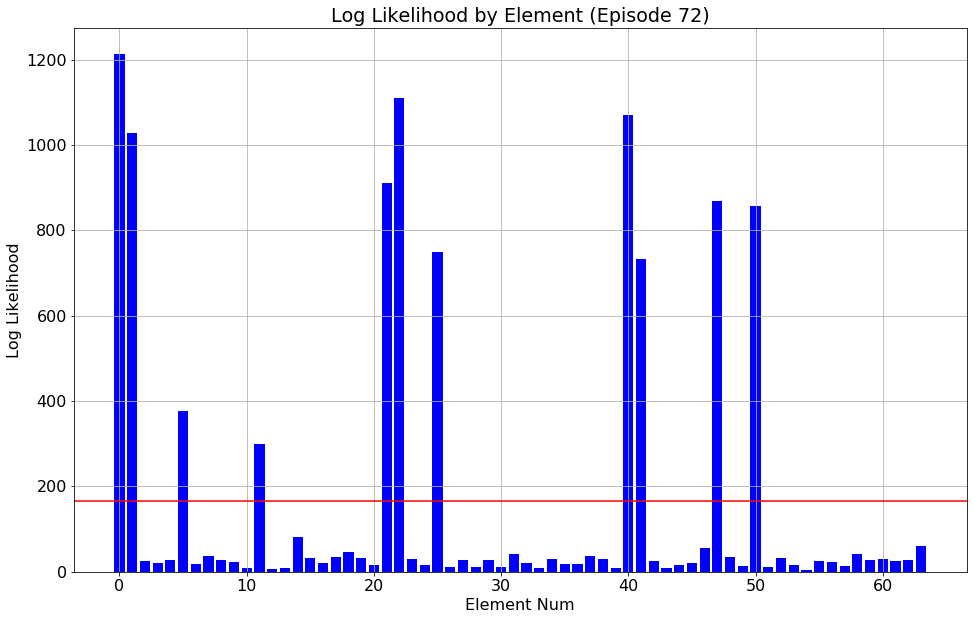

In [37]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [38]:
fig.savefig('../figs/search_known/perturbed_large/log_like.png', bbox_inches='tight')

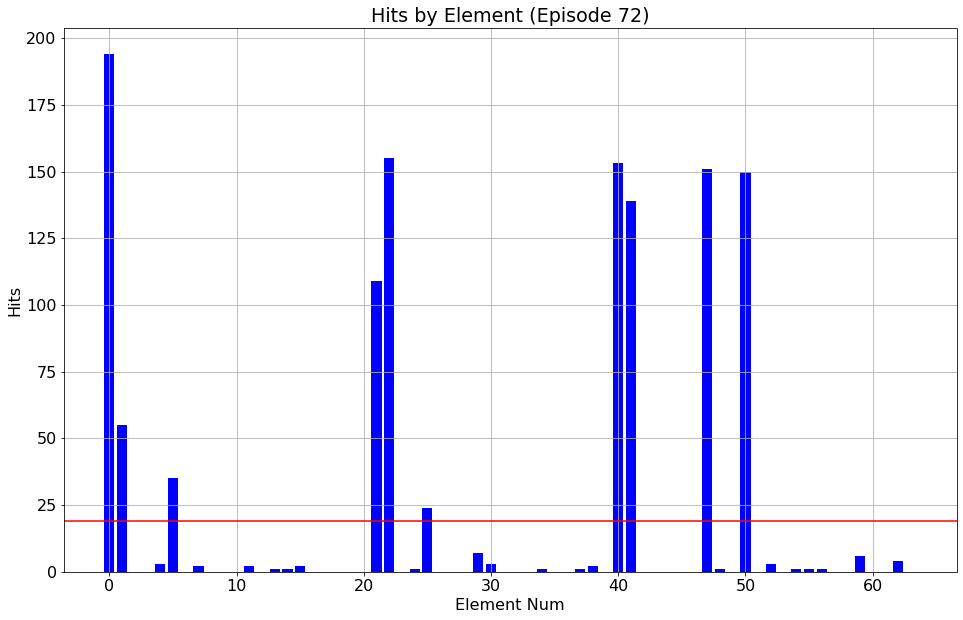

In [39]:
# Bar chart: hits
fig, ax_hits = model.plot_bar('hits', sorted=False)

In [40]:
fig.savefig('../figs/search_known/perturbed_large/hits.png', bbox_inches='tight')

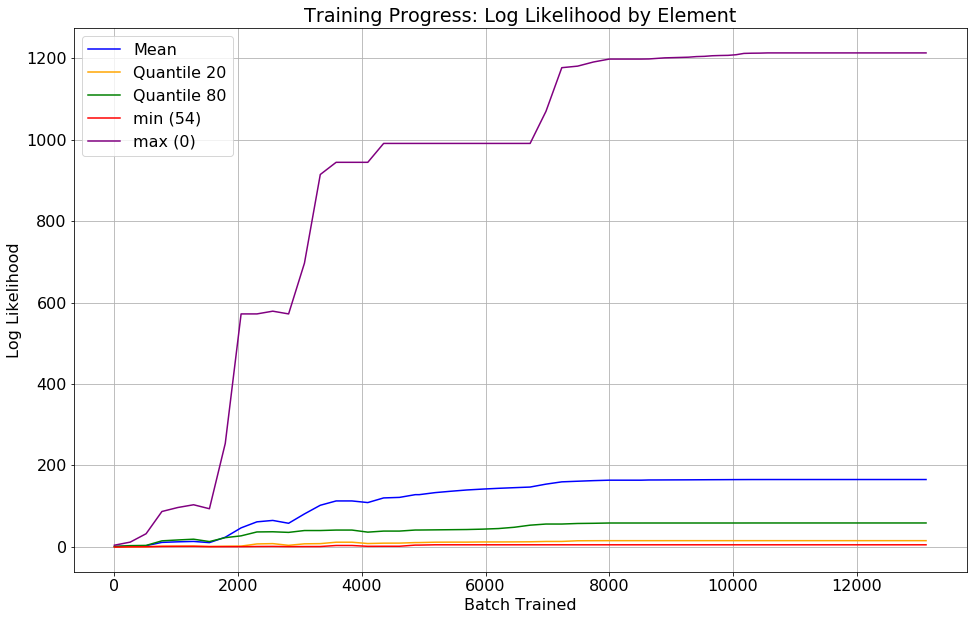

In [41]:
# Learning curve: log likelihood
fig, ax_lc_like = model.plot_hist('log_like')

In [42]:
fig.savefig('../figs/search_known/perturbed_large/learning_curve_log_like.png', bbox_inches='tight')

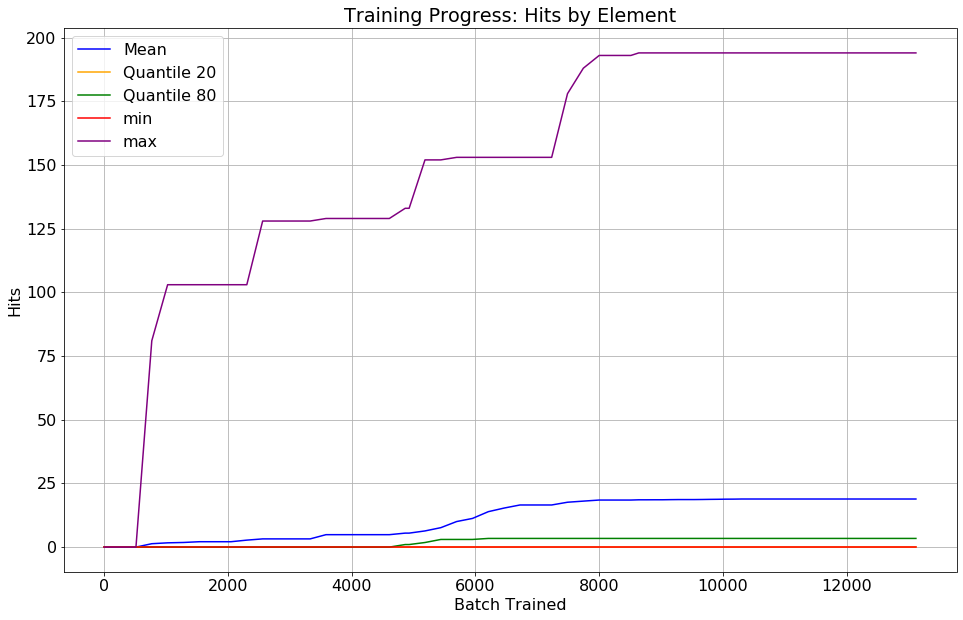

In [43]:
# Learning curve: hits
fig, ax_lc_hits = model.plot_hist('hits')

In [44]:
fig.savefig('../figs/search_known/perturbed_large/learning_curve_hits.png', bbox_inches='tight')

## Distance vs. Nearest Asteroid for Fitted Elements

In [45]:
elts_fit, elts_near = model.nearest_ast()

In [46]:
model.report()


Good elements (hits >= 5):  12.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   748.07  :  98.17 :    61.36 :  1178.94
Mean Bad :    30.35  :   0.58 :   261.02 :  2296.18
Mean     :   164.92  :  18.88 :   223.58 :  2086.70
Median   :    27.62  :   0.00 :   188.59 :  2400.00
GeoMean  :    39.63  :   1.82 :   142.59 :  1959.11
Min      :     4.48  :   0.00 :     7.49 :   375.54
Max      :  1213.48  : 194.00 :   862.12 :  2400.00
Trained for 13120 batches over 205 epochs and 72 episodes (elapsed time 533 seconds).


In [47]:
# model.save_state()

In [50]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 5)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.exp(np.mean(np.log(model.elts_fit.R_sec[is_converged])))
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 12 asteroids.
Mean on converged asteroids:
Number of hits         : 98.17
Resolution in arc sec  : 32.44
GeoMean Distance in AU : 4.45e-04
Covariance norm        : 3.32e-02


In [49]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,1213.478394,194.0,21.715118,1238.764038,51921,0.000119,0.001825
22,9229,1110.033691,155.0,8.312490,638.256042,9229,0.000228,0.015043
40,31539,1071.736816,153.0,7.485936,413.550751,31539,0.000598,0.035009
47,733,870.164917,151.0,28.779037,993.650269,733,0.000156,0.027326
50,6455,857.743408,150.0,24.002638,993.451172,6455,0.000007,0.000115
41,3426,734.083557,139.0,29.237883,1007.421265,3426,0.000350,0.073068
21,77774,911.999390,109.0,11.987228,375.536682,77774,0.000785,0.029604
1,59244,1028.321899,55.0,35.122875,1202.841431,59244,0.000219,0.065282
5,5817,376.742340,35.0,108.123978,1445.589844,5817,0.004975,0.175037
25,203722,748.454041,24.0,31.834160,1038.231323,203722,0.001514,0.027254


In [51]:
# # Review fitted elements including nearest asteroid
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,2.669817,0.217465,0.499591,4.699666,2.450917,-1.133483,58600.0,194.907074,0.000105,...,0.344101,1238.764038,1213.478394,194.0,331.0,16.500002,1.0,51921,0.000119,0.001825
1,59244,2.634270,0.263111,0.464929,5.737987,1.773892,-1.606727,58600.0,190.232513,0.000170,...,0.334123,1202.841431,1028.321899,55.0,256.0,16.500002,1.0,59244,0.000219,0.065282
2,15786,1.943340,0.050985,0.385246,6.140264,0.788094,-1.248503,58600.0,17.983421,0.000383,...,0.612161,2203.780762,26.376791,0.0,314.0,16.500002,1.0,311969,0.003011,1.041769
3,3904,2.753654,0.114943,0.250261,5.527285,2.192284,-1.373379,58600.0,35.203945,0.001220,...,0.666667,2399.999756,21.688103,0.0,421.0,16.500002,1.0,1201865,0.004481,0.486497
4,142999,2.554483,0.190477,0.507308,0.214194,0.927508,-1.325456,58600.0,13.420828,0.000203,...,0.618138,2225.295410,28.082857,3.0,366.0,16.500002,1.0,76380,0.010477,2.480698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.331433,0.090456,0.119217,0.124673,2.857708,-3.033468,58600.0,31.066372,0.000514,...,0.666667,2399.999756,27.447979,6.0,1181.0,16.500002,1.0,64103,0.002580,0.704941
60,134815,2.420290,0.117237,0.503422,0.240110,0.624006,-0.923831,58600.0,48.084373,0.001411,...,0.666667,2399.999756,31.163317,0.0,364.0,16.500002,1.0,486319,0.009916,2.742909
61,27860,2.596753,0.098754,0.194435,5.534238,3.256792,3.967808,58600.0,44.857822,0.000961,...,0.666667,2399.999756,24.651583,0.0,988.0,16.500002,1.0,1047580,0.004137,0.967311
62,85937,2.183119,0.193894,0.433887,5.239220,3.129986,3.967098,58600.0,31.808922,0.000868,...,0.666667,2399.999756,28.666922,4.0,384.0,16.500002,1.0,45947,0.011705,3.981006


In [52]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
40,31539,153.981842,7.485936,413.550751,1071.736816,153.0,0.000598,0.035009
22,9229,162.901047,8.312490,638.256042,1110.033691,155.0,0.000228,0.015043
21,77774,163.957016,11.987228,375.536682,911.999390,109.0,0.000785,0.029604
0,51921,194.907074,21.715118,1238.764038,1213.478394,194.0,0.000119,0.001825
50,6455,150.897095,24.002638,993.451172,857.743408,150.0,0.000007,0.000115
47,733,151.379425,28.779037,993.650269,870.164917,151.0,0.000156,0.027326
41,3426,152.675354,29.237883,1007.421265,734.083557,139.0,0.000350,0.073068
25,203722,161.231369,31.834160,1038.231323,748.454041,24.0,0.001514,0.027254
1,59244,190.232513,35.122875,1202.841431,1028.321899,55.0,0.000219,0.065282


In [53]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

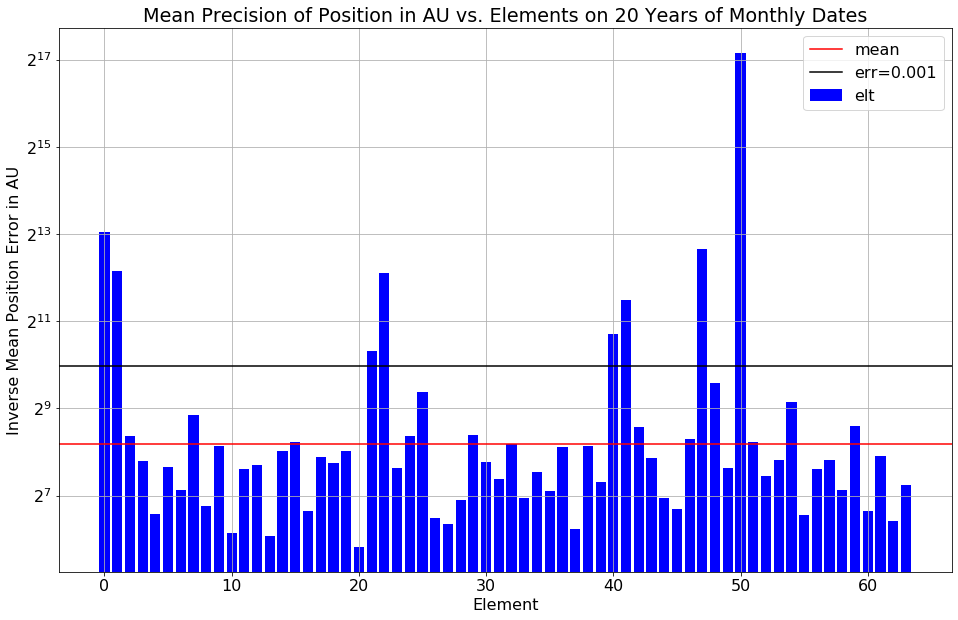

In [54]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

In [55]:
fig.savefig('../figs/search_known/perturbed_large/near_ast_dist.png', bbox_inches='tight')

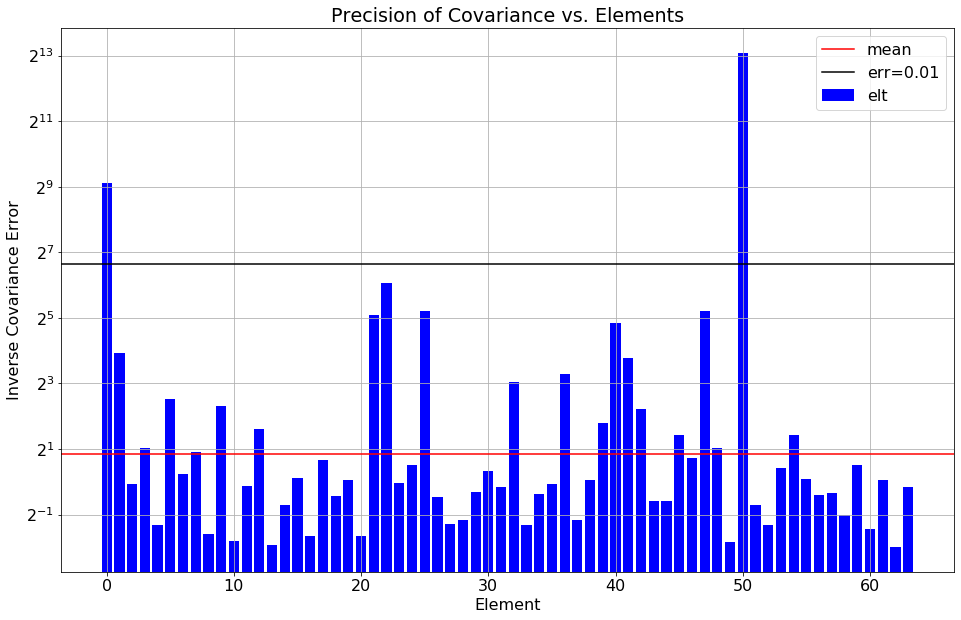

In [56]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [57]:
fig.savefig('../figs/search_known/perturbed_large/near_ast_cov.png', bbox_inches='tight')

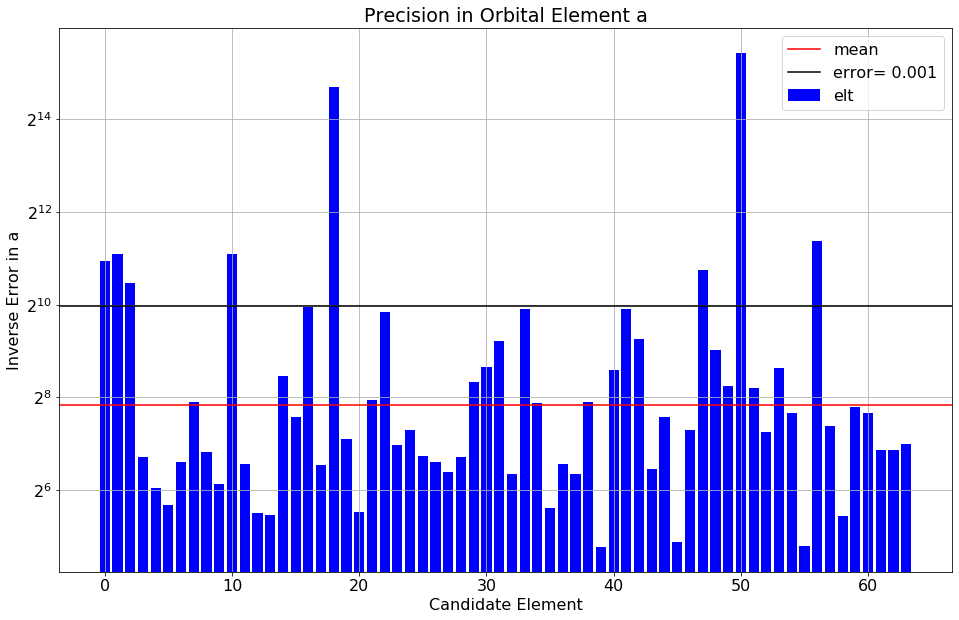

In [58]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

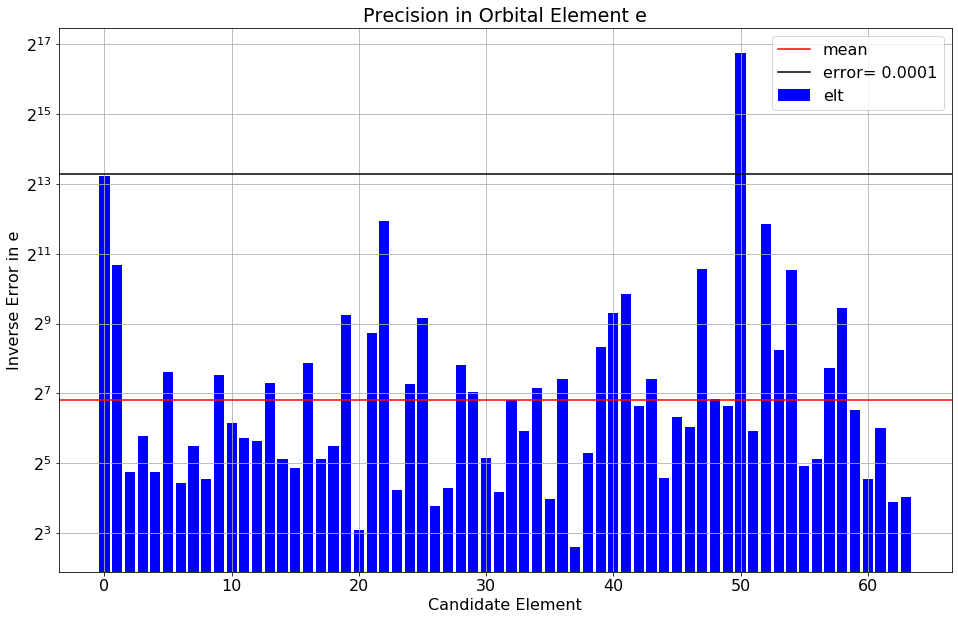

In [59]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

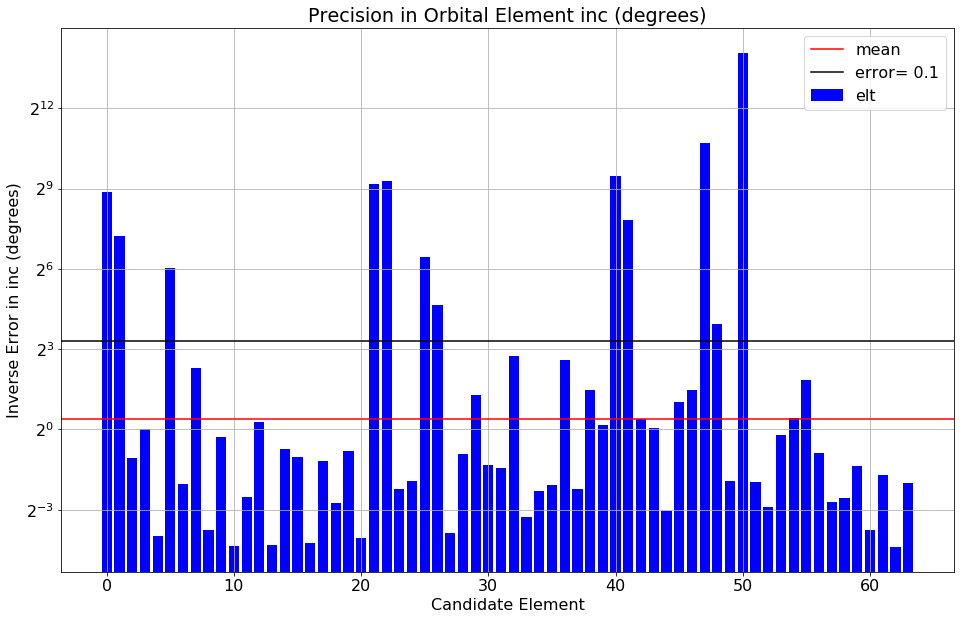

In [60]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

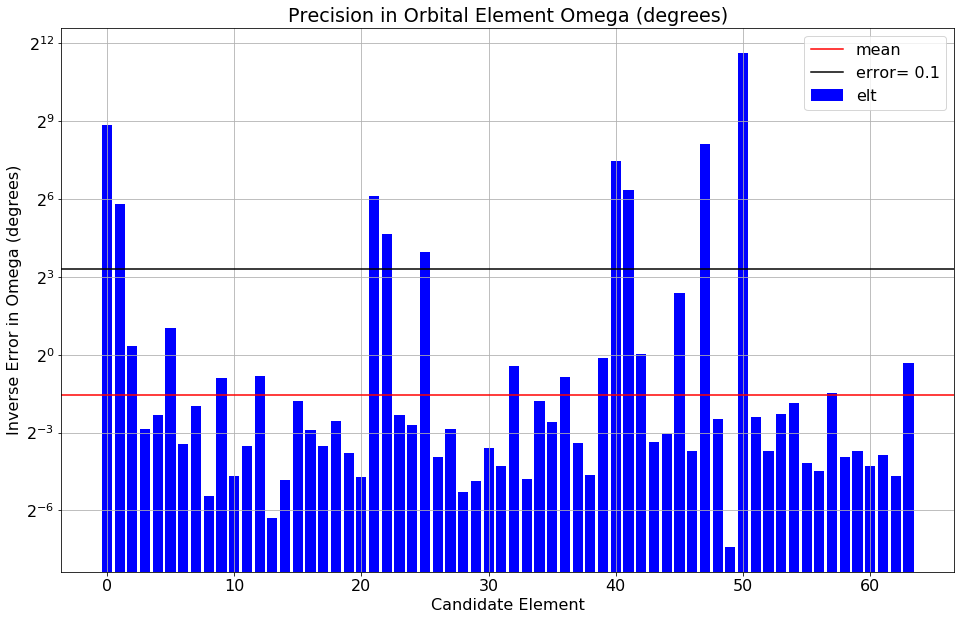

In [61]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

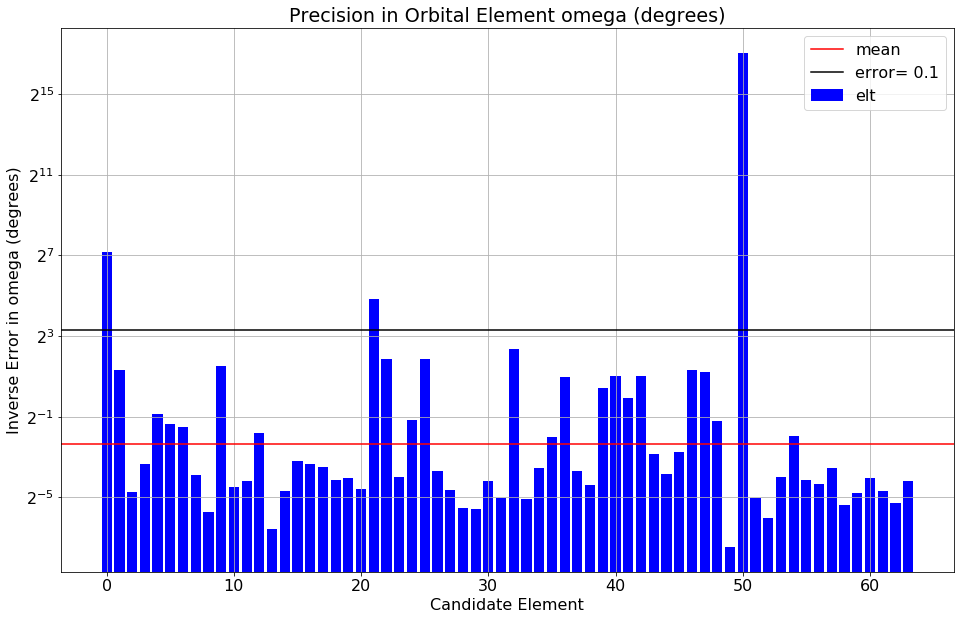

In [62]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

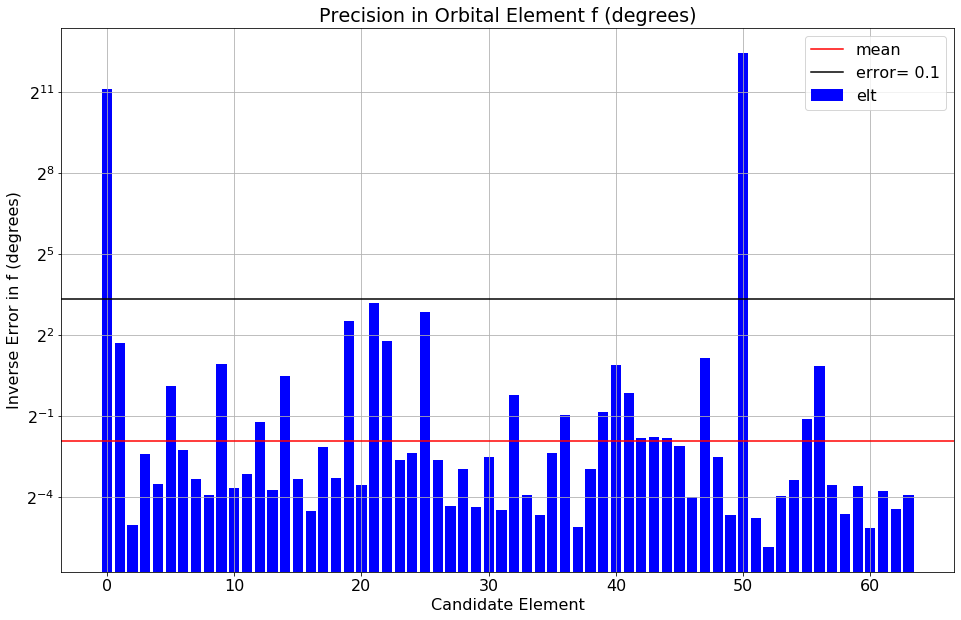

In [63]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)

In [ ]:
model.candidates_df()